In [1]:
# load in entity_const.csv into a df
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

entity_const = pd.read_csv('../data/entity_const.csv')
entity_const

MP_geometry = pd.read_csv('../data/MP_geometry.csv')
MP_geometry = gpd.GeoDataFrame(MP_geometry)
MP_geometry['geometry'] = gpd.GeoSeries.from_wkt(MP_geometry['geometry'])


# load questions
questions = pd.read_csv('../data/questions.csv')
questions.columns

Index(['question', 'qnum', 'person', 'wikidataperson', 'text', 'date'], dtype='object')

In [2]:
questions.head(3)

,question,qnum,person,wikidataperson,text,date
0,https://id.parliament.uk/0IwOO533,903422,https://id.parliament.uk/Vs3bGLNz,http://www.wikidata.org/entity/Q689287,Which three departments had the lowest proport...,2023-01-05+00:00
1,https://id.parliament.uk/dRJ9254g,117748,https://id.parliament.uk/eD0yd5Ec,http://www.wikidata.org/entity/Q19871931,"To ask the Secretary of State for Foreign, Com...",2023-01-06+00:00
2,https://id.parliament.uk/e4IDRkKi,117410,https://id.parliament.uk/RlIqlixq,http://www.wikidata.org/entity/Q695228,"To ask the Secretary of State for Foreign, Com...",2023-01-06+00:00


In [3]:
entity_const

,question,entity,easting,northing,wikipedia,const
0,https://id.parliament.uk/wne3Q3kQ,West_Midlands_(region),382689.369764,286801.459728,https://en.wikipedia.org/wiki/West_Midlands_(r...,South Staffordshire
1,https://id.parliament.uk/Q0uNVDhz,Slough,498082.779241,179773.798368,https://en.wikipedia.org/wiki/Slough,Slough
2,https://id.parliament.uk/oHeIeP9G,River_Tees,455114.463816,528466.390692,https://en.wikipedia.org/wiki/River_Tees,Redcar
3,https://id.parliament.uk/W7K6780e,Hounslow,512974.190267,175455.283371,https://en.wikipedia.org/wiki/Hounslow,Feltham and Heston
4,https://id.parliament.uk/e9R3Yc8s,Buckingham_(UK_Parliament_constituency),469572.352087,233989.735822,https://en.wikipedia.org/wiki/Buckingham_(UK_P...,Buckingham
...,...,...,...,...,...,...
2580,https://id.parliament.uk/KBjXJ9mO,Portsmouth,464413.884270,101094.379827,https://en.wikipedia.org/wiki/Portsmouth,Portsmouth South
2581,https://id.parliament.uk/51DqbupU,HM_Prison_Wandsworth,526728.635699,173925.158213,https://en.wikipedia.org/wiki/HM_Prison_Wandsw...,Tooting
2582,https://id.parliament.uk/c7mhUeV3,Rathlin_Island,133639.823902,608129.542743,https://en.wikipedia.org/wiki/Rathlin_Island,North Antrim
2583,https://id.parliament.uk/Py4BvdeG,Downing_Street_mortar_attack,530021.784566,179958.304242,https://en.wikipedia.org/wiki/Downing_Street_m...,Cities of London and Westminster


In [4]:
entity_const

,question,entity,easting,northing,wikipedia,const
0,https://id.parliament.uk/wne3Q3kQ,West_Midlands_(region),382689.369764,286801.459728,https://en.wikipedia.org/wiki/West_Midlands_(r...,South Staffordshire
1,https://id.parliament.uk/Q0uNVDhz,Slough,498082.779241,179773.798368,https://en.wikipedia.org/wiki/Slough,Slough
2,https://id.parliament.uk/oHeIeP9G,River_Tees,455114.463816,528466.390692,https://en.wikipedia.org/wiki/River_Tees,Redcar
3,https://id.parliament.uk/W7K6780e,Hounslow,512974.190267,175455.283371,https://en.wikipedia.org/wiki/Hounslow,Feltham and Heston
4,https://id.parliament.uk/e9R3Yc8s,Buckingham_(UK_Parliament_constituency),469572.352087,233989.735822,https://en.wikipedia.org/wiki/Buckingham_(UK_P...,Buckingham
...,...,...,...,...,...,...
2580,https://id.parliament.uk/KBjXJ9mO,Portsmouth,464413.884270,101094.379827,https://en.wikipedia.org/wiki/Portsmouth,Portsmouth South
2581,https://id.parliament.uk/51DqbupU,HM_Prison_Wandsworth,526728.635699,173925.158213,https://en.wikipedia.org/wiki/HM_Prison_Wandsw...,Tooting
2582,https://id.parliament.uk/c7mhUeV3,Rathlin_Island,133639.823902,608129.542743,https://en.wikipedia.org/wiki/Rathlin_Island,North Antrim
2583,https://id.parliament.uk/Py4BvdeG,Downing_Street_mortar_attack,530021.784566,179958.304242,https://en.wikipedia.org/wiki/Downing_Street_m...,Cities of London and Westminster


In [5]:
"""Number of questions that include each constituency"""

# group the entities extracted from the questions by constituency and count the number of entities in each constituency
entity_occurrences = pd.DataFrame(entity_const.groupby("const")["question"].count().sort_values(ascending=False)).reset_index()
entity_occurrences.rename(columns={"question": "occurrences"}, inplace=True)

# join to a df containing the geometry of each MP's constituency. We drop duplicates because some constituencies have had multiple MPs
entity_occurrences = pd.merge(MP_geometry[["constLabel", "geometry"]].drop_duplicates(), entity_occurrences, left_on="constLabel", right_on="const", how="left")
entity_occurrences.drop(columns="const", inplace=True)

entity_occurrences = gpd.GeoDataFrame(entity_occurrences)

# set the geometry column
entity_occurrences = entity_occurrences.set_geometry("geometry")

# if a constituency has no mentions, fill the value with 0
entity_occurrences.fillna(0, inplace=True)



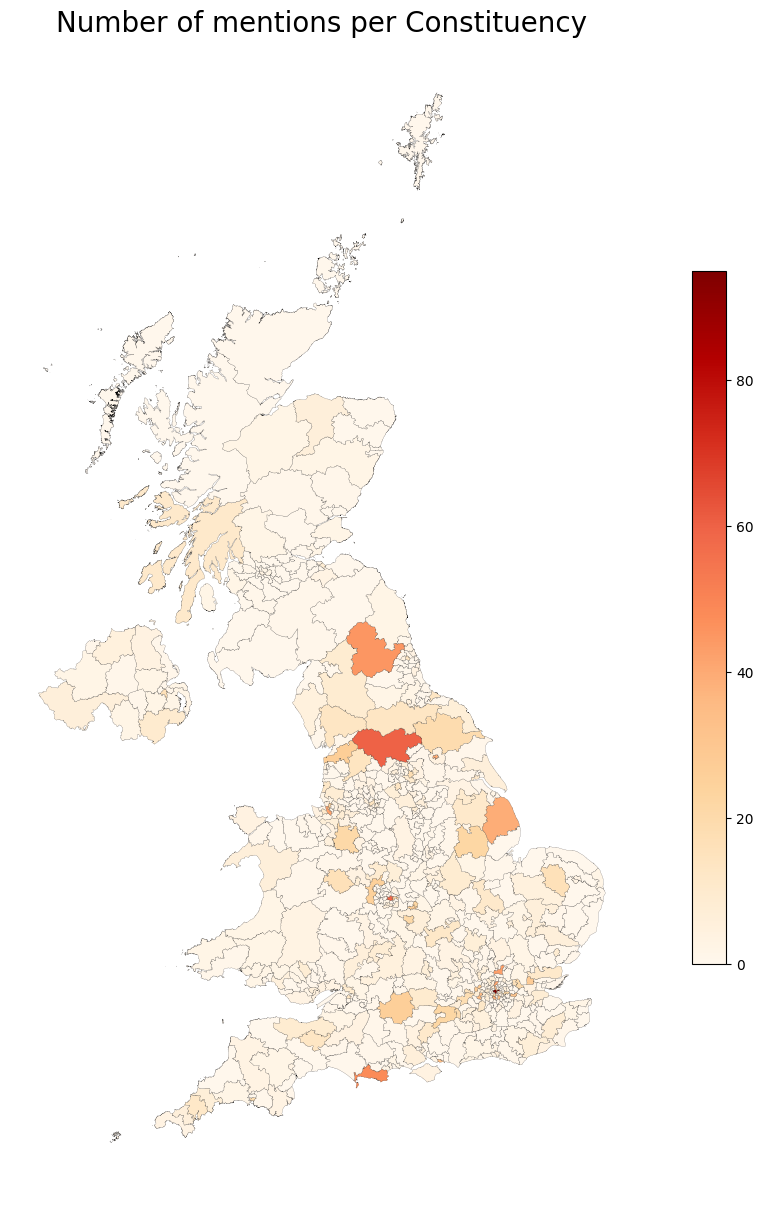

In [6]:
fig, ax = plt.subplots(figsize=(15, 15))


entity_occurrences.plot(ax=ax, column="occurrences", legend=True, cmap="OrRd" , edgecolor="black", linewidth=0.1, legend_kwds={"shrink":0.6}) #cmap="OrRd"
# centre title
plt.title("Number of mentions per Constituency", fontsize=20)
# remove axis labels
ax.set_axis_off()

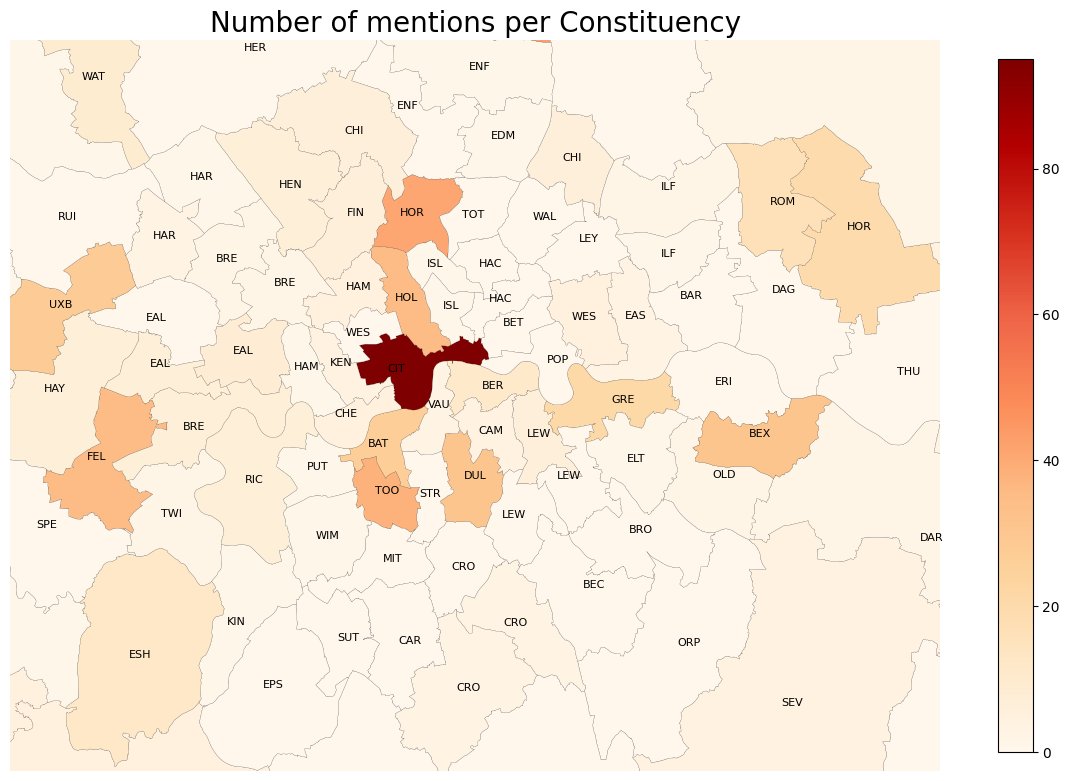

In [7]:
# Plots the number of mentions and limits the axes to inside London

fig, ax = plt.subplots(figsize=(15, 15))

entity_occurrences.plot(ax=ax, column="occurrences", legend=True, cmap="OrRd" , edgecolor="black", linewidth=0.1, legend_kwds={'shrink':0.6}) #cmap="OrRd"


# help to annotate the shapes https://stackoverflow.com/questions/38899190/geopandas-label-polygons 

# produce coordinates inside the polygon geometries to place the labels
entity_occurrences["coords"] = entity_occurrences["geometry"].apply(lambda x: x.representative_point().coords[:])
entity_occurrences["coords"] = [coords[0] for coords in entity_occurrences["coords"]]

for index, row in entity_occurrences.iterrows():
    plt.annotate(text=row["constLabel"][:3].upper(), xy=row["coords"], horizontalalignment='center', fontsize=8)

plt.title("Number of mentions per Constituency", fontsize=20)

# limit the axes to inside London
ax.set_ylim(156_000, 200_000)
ax.set_xlim(505_000, 561_000)
ax.set_axis_off()


In [8]:
"""Join the question entity with the MP who asked the question and their constituency"""

# a question was asked about this constituency by this MP who is from this place and has this area.


# merge the geometry of the MP's constituency with the entity in the question and the entity's constituency
joined_df = pd.merge(
            # merge the constituencies of entities with the specific question asking it
            # I have done this to get the MP who asked the question
            pd.merge(
                entity_const, questions, how="left", right_on="question", left_on="question"
                ), 
                
                MP_geometry, how="left", left_on="wikidataperson", right_on="person")




joined_df= joined_df[["question", "const_x", "personLabel", "constLabel", "geometry"]]

joined_df.rename(columns={"const_x":"question_const", "personLabel":"MP", "constLabel":"MP_const", "geometry":"MP_const_geometry"}, inplace=True)
joined_df

,question,question_const,MP,MP_const,MP_const_geometry
0,https://id.parliament.uk/wne3Q3kQ,South Staffordshire,Steve McCabe,Birmingham Selly Oak,"POLYGON ((402823.398 282975.698, 402819.399 28..."
1,https://id.parliament.uk/Q0uNVDhz,Slough,Tanmanjeet Singh Dhesi,Slough,"POLYGON ((494342.702 178838.997, 494338.497 17..."
2,https://id.parliament.uk/oHeIeP9G,Redcar,Rachael Maskell,York Central,"POLYGON ((461843.903 454083.299, 461851.703 45..."
3,https://id.parliament.uk/W7K6780e,Feltham and Heston,Ruth Cadbury,Brentford and Isleworth,"POLYGON ((521351.824 179500.313, 521353.700 17..."
4,https://id.parliament.uk/e9R3Yc8s,Buckingham,Julian Knight,Solihull,"POLYGON ((416312.499 283687.905, 416335.898 28..."
...,...,...,...,...,...
2580,https://id.parliament.uk/KBjXJ9mO,Portsmouth South,Stephen Morgan,Portsmouth South,"MULTIPOLYGON (((463418.899 101737.297, 464118...."
2581,https://id.parliament.uk/51DqbupU,Tooting,Rosena Allin-Khan,Tooting,"POLYGON ((525760.499 174242.503, 525769.000 17..."
2582,https://id.parliament.uk/c7mhUeV3,North Antrim,Andrew Rosindell,Romford,"POLYGON ((548106.898 193800.904, 548224.704 19..."
2583,https://id.parliament.uk/Py4BvdeG,Cities of London and Westminster,Emily Thornberry,Islington South and Finsbury,"POLYGON ((529818.713 184985.372, 529825.652 18..."


In [9]:
"""Number of questions per constituency."""

# group the questions by the constituency of the MP who asked the question and the geometry of the constituency
const_questions = pd.DataFrame(joined_df.groupby(["MP_const"])["MP"].count()
                               ).reset_index()
const_questions.rename(columns={"MP": "questions"}, inplace=True)

# add the names of the remaining constituencies that there MP have asked no questions, and join the geometry of all the constituencies back
const_questions = pd.merge(MP_geometry[["constLabel", "geometry"]].drop_duplicates(), const_questions, left_on="constLabel", right_on="MP_const", how="left")
const_questions.drop(columns="MP_const", inplace=True)
const_questions.fillna(0, inplace=True)

const_questions.set_geometry("geometry")
const_questions = gpd.GeoDataFrame(const_questions)

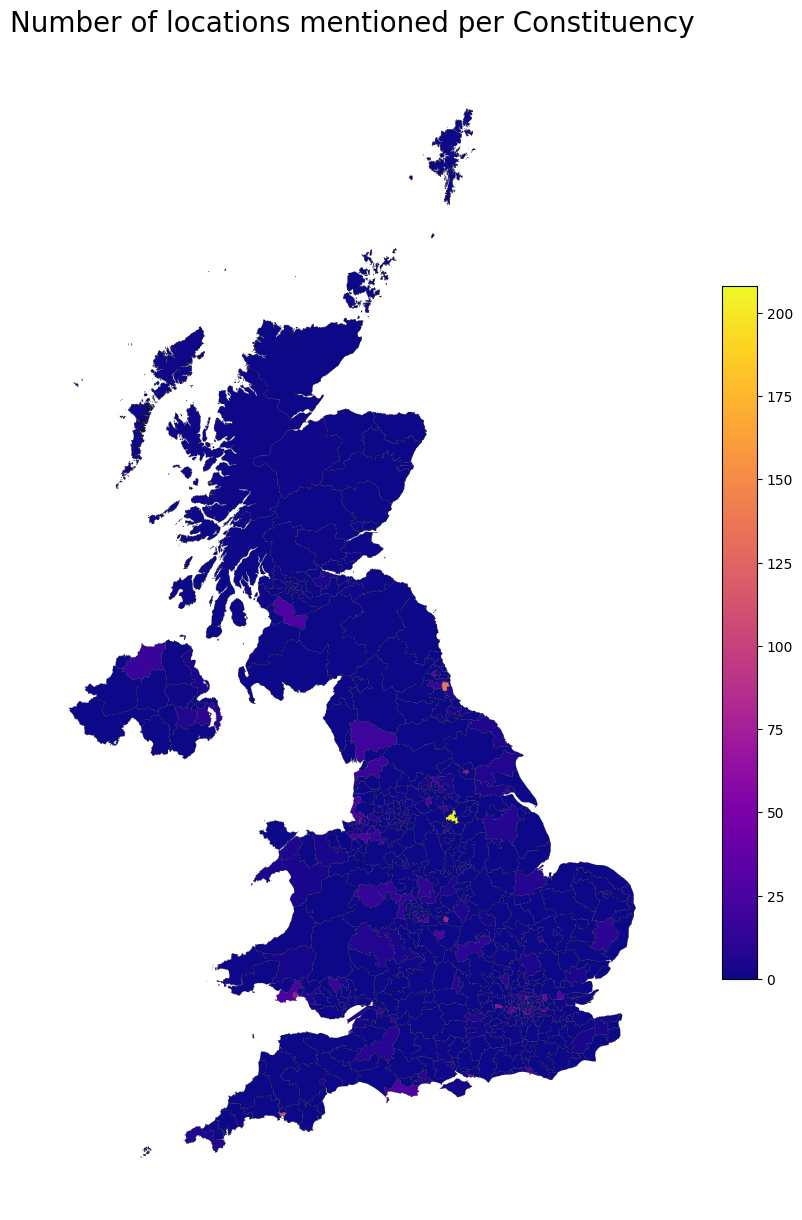

In [10]:
fig,ax = plt.subplots(figsize=(15, 15))
const_questions.plot(ax=ax, column="questions", legend=True, cmap="plasma" , edgecolor="black", linewidth=0.1, legend_kwds={"shrink":0.6})
plt.title("Number of locations mentioned per Constituency", fontsize=20)
ax.set_axis_off()

In [135]:
"""
Number of question made by MP's about their own constituency

"""


# count the number of times for each entity that the MP's constituency is the same as the entitie's
joined_df["same_const"] = joined_df["question_const"] == joined_df["MP_const"]

same_const = joined_df.groupby("MP_const")["same_const"].sum().reset_index()
same_const["same_const"].min()
# merge the geometries back to the consitituencies and add the constituencies that asked no questions at all
# I drop duplicates as two or more MP's may have represented the same constituency in the MP_geometry during the 58th parliment.
# same_const = pd.merge(MP_geometry[["constLabel", "geometry"]].drop_duplicates(), same_const, left_on="constLabel", right_on="MP_const", how="left")
# same_const.drop(columns="MP_const", inplace=True)
# same_const = same_const.set_geometry("geometry")
# same_const.isna().sum()

0

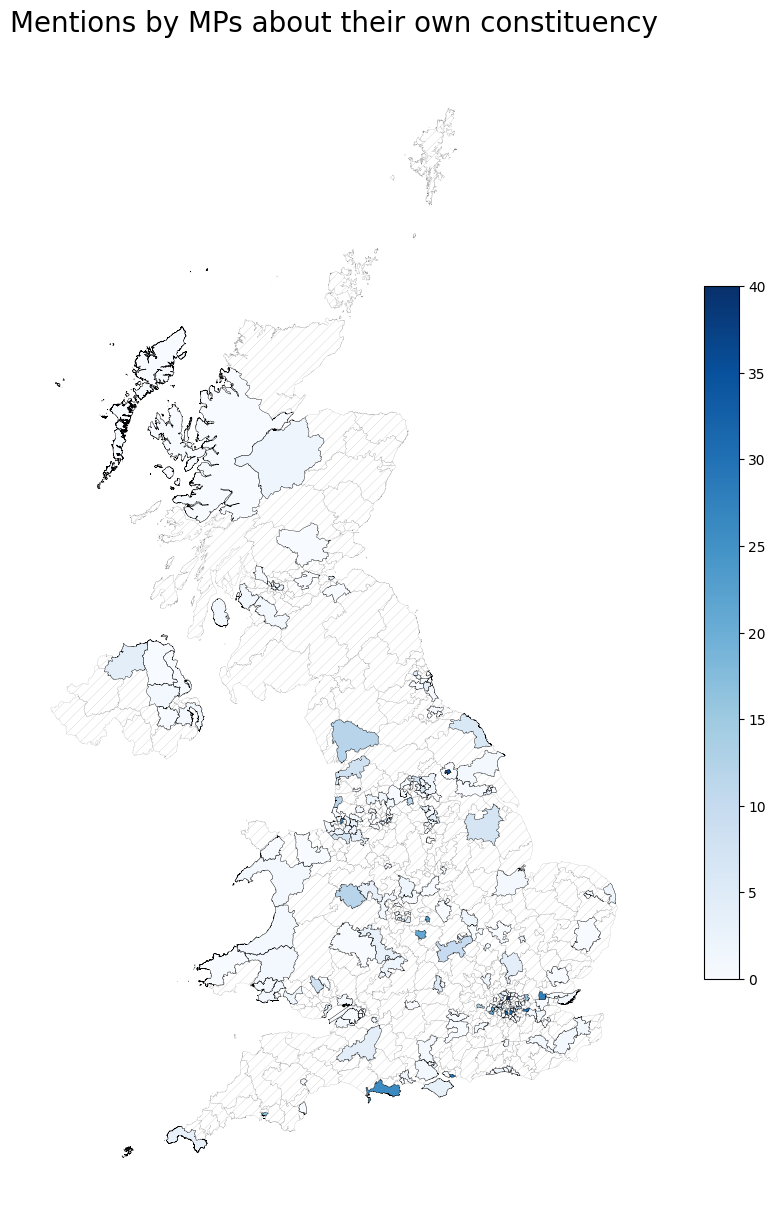

In [12]:
fig, ax = plt.subplots(figsize=(15, 15))


same_const.plot(ax=ax, column="same_const", legend=True, cmap="Blues", edgecolor="black", linewidth=0.3, legend_kwds={"shrink":0.6}) #cmap="OrRd"
same_const[same_const["same_const"].isnull()].plot(ax=ax, color="white", edgecolor="black", linewidth=0.1, hatch="///", alpha=0.5)
plt.title("Mentions by MPs about their own constituency", fontsize=20)
# remove axis labels
ax.set_axis_off()
plt.rcParams['hatch.linewidth'] = 0.1

In [13]:
# Proportion of questions asked by MP's about their own constituency
"""
Proportion of question made by MP's about their own constituency

"""
proportion_same_const = []

# go through all constituencies that asked questions
for const in joined_df["MP_const"].unique():
    # group by the MP's constituency and sum the number of times the entity was the same
    same = joined_df[joined_df["MP_const"] == const]["same_const"].sum()

    # take the total number of entities mentioned by the MP
    total = (joined_df["MP_const"] == const).sum()

    
    proportion_same_const.append([const,same/total])


proportion_same_const = gpd.GeoDataFrame(proportion_same_const, columns=["const", "proportion_same_const"])

# merge with the geometry of all constituencies
proportion_same_const = pd.merge(MP_geometry[["constLabel", "geometry"]], proportion_same_const, left_on="constLabel", right_on="const", how="left")
proportion_same_const.drop(columns="const", inplace=True)

proportion_same_const


proportion_same_const = proportion_same_const.set_geometry("geometry")
proportion_same_const

,constLabel,geometry,proportion_same_const
0,Witney,"POLYGON ((442095.596 201006.402, 442061.503 20...",NaN
1,Gower,"POLYGON ((266481.698 209849.500, 266493.299 20...",0.037037
2,Dumfries and Galloway,"MULTIPOLYGON (((266001.597 603288.500, 266016....",NaN
3,Blaydon,"POLYGON ((411599.496 556797.514, 411599.430 55...",NaN
4,Banff and Buchan,"MULTIPOLYGON (((352324.388 867640.741, 352328....",NaN
...,...,...,...
664,East Devon,"POLYGON ((294508.731 96046.540, 294508.510 960...",NaN
665,Loughborough,"POLYGON ((450929.602 315678.597, 450928.201 31...",NaN
666,Jarrow,"POLYGON ((435134.003 566077.102, 435320.399 56...",NaN
667,Buckingham,"POLYGON ((460619.899 235588.003, 460625.870 23...",NaN


In [14]:
joined_df

,question,question_const,MP,MP_const,MP_const_geometry,same_const
0,https://id.parliament.uk/wne3Q3kQ,South Staffordshire,Steve McCabe,Birmingham Selly Oak,"POLYGON ((402823.398 282975.698, 402819.399 28...",False
1,https://id.parliament.uk/Q0uNVDhz,Slough,Tanmanjeet Singh Dhesi,Slough,"POLYGON ((494342.702 178838.997, 494338.497 17...",True
2,https://id.parliament.uk/oHeIeP9G,Redcar,Rachael Maskell,York Central,"POLYGON ((461843.903 454083.299, 461851.703 45...",False
3,https://id.parliament.uk/W7K6780e,Feltham and Heston,Ruth Cadbury,Brentford and Isleworth,"POLYGON ((521351.824 179500.313, 521353.700 17...",False
4,https://id.parliament.uk/e9R3Yc8s,Buckingham,Julian Knight,Solihull,"POLYGON ((416312.499 283687.905, 416335.898 28...",False
...,...,...,...,...,...,...
2580,https://id.parliament.uk/KBjXJ9mO,Portsmouth South,Stephen Morgan,Portsmouth South,"MULTIPOLYGON (((463418.899 101737.297, 464118....",True
2581,https://id.parliament.uk/51DqbupU,Tooting,Rosena Allin-Khan,Tooting,"POLYGON ((525760.499 174242.503, 525769.000 17...",True
2582,https://id.parliament.uk/c7mhUeV3,North Antrim,Andrew Rosindell,Romford,"POLYGON ((548106.898 193800.904, 548224.704 19...",False
2583,https://id.parliament.uk/Py4BvdeG,Cities of London and Westminster,Emily Thornberry,Islington South and Finsbury,"POLYGON ((529818.713 184985.372, 529825.652 18...",False


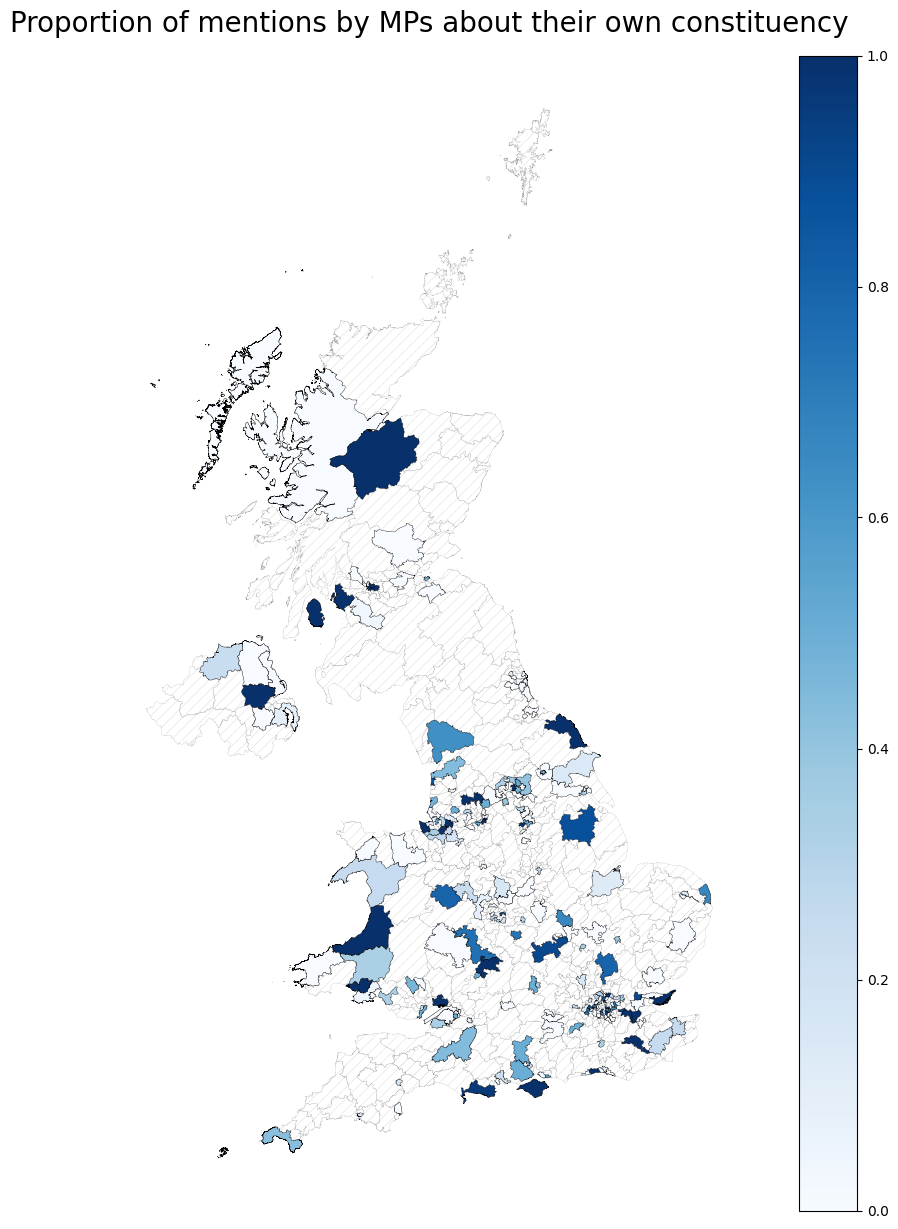

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))
proportion_same_const.plot(ax=ax, column="proportion_same_const", legend=True, cmap="Blues", edgecolor="black", linewidth=0.3)
proportion_same_const[proportion_same_const["proportion_same_const"].isna()].plot(ax=ax, color="white", edgecolor="black", linewidth=0.1, hatch="///", alpha=0.5)
plt.rcParams['hatch.linewidth'] = 0.1
plt.title("Proportion of mentions by MPs about their own constituency", fontsize=20)

ax.set_axis_off()
plt.savefig("../visualisations/proportion_same_const.png", dpi=300, bbox_inches='tight')

<Axes: xlabel='proportion_same_const', ylabel='Count'>

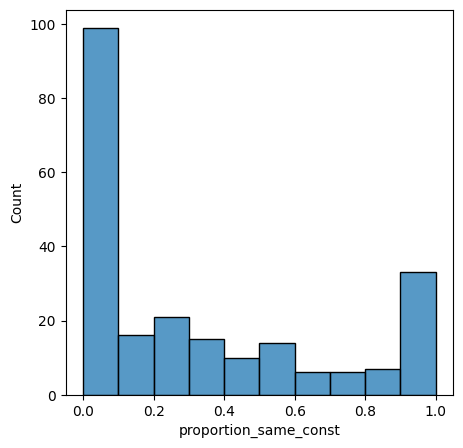

In [16]:
# show the proportion of questions asked by MP's about their own constituency using a histogram
import seaborn as sns

fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(data=proportion_same_const, x="proportion_same_const", bins=10)


In [170]:
# take all entities mentioned by MPs about their own constituency
joined_df["same_const"] = joined_df["question_const"] == joined_df["MP_const"]

same_const = joined_df[joined_df["same_const"]]
same_const

# take each question by the MP that metions their constituency (by removing duplicates, where it is referenced multiple times in a question)
same_const = same_const.drop_duplicates(subset=["question"])
same_const = same_const.groupby("MP_const")["same_const"].count().reset_index()

same_const
# add geometries back for all constituencies
same_const = pd.merge(MP_geometry[["constLabel", "geometry"]].drop_duplicates(), same_const, left_on="constLabel", right_on="MP_const", how="left")
same_const.drop(columns="MP_const", inplace=True)
same_const = same_const.set_geometry("geometry")

question_counts = pd.merge(questions, MP_geometry[["person", "constLabel"]], left_on="wikidataperson", right_on="person").groupby(["constLabel"])["question"].count().reset_index()
question_counts.rename(columns={"question": "total_questions"}, inplace=True)

# fill in na for constituencies that have total questions greater than 0
same_const = pd.merge(same_const, question_counts, on="constLabel", how="left")
same_const[~same_const["total_questions"].isna()] = same_const[~same_const["total_questions"].isna()].fillna(0)

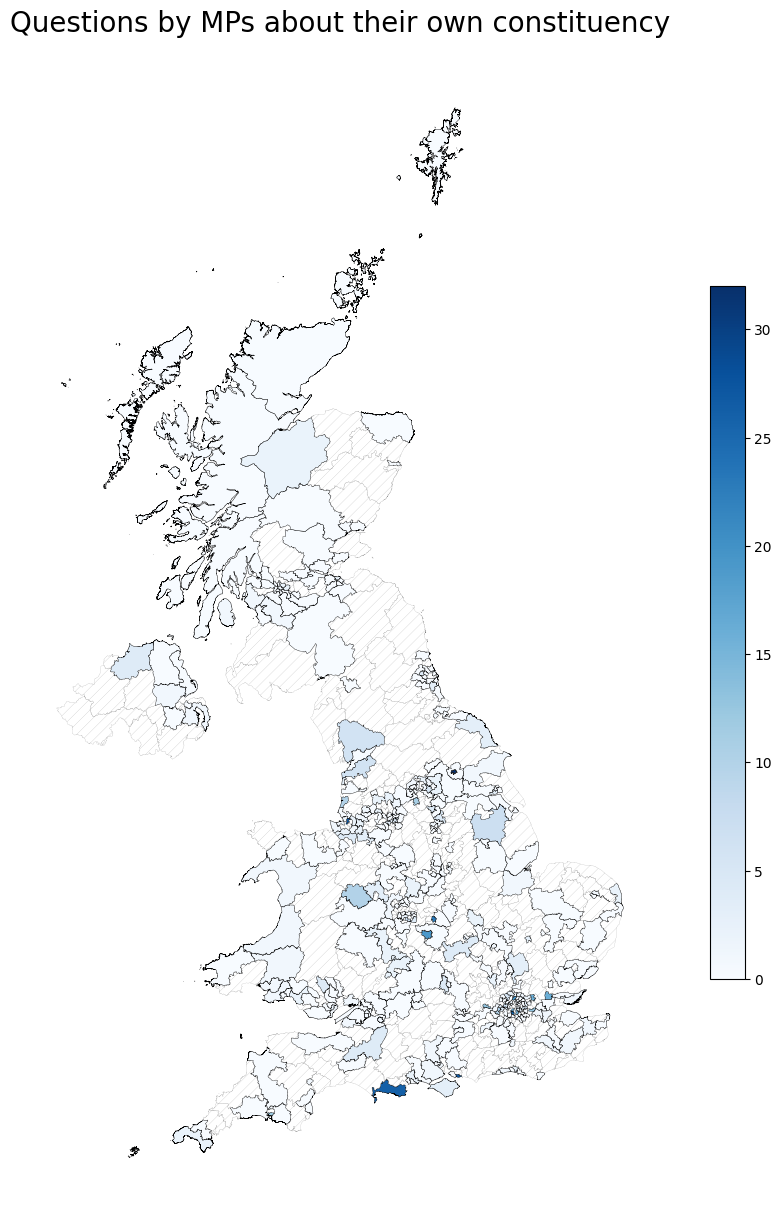

In [171]:
fig, ax = plt.subplots(figsize=(15, 15))


same_const.plot(ax=ax, column="same_const", legend=True, cmap="Blues", edgecolor="black", linewidth=0.3, legend_kwds={"shrink":0.6}) #cmap="OrRd"
same_const[same_const["same_const"].isnull()].plot(ax=ax, color="white", edgecolor="black", linewidth=0.1, hatch="///", alpha=0.5)
plt.title("Questions by MPs about their own constituency", fontsize=20)
# remove axis labels
ax.set_axis_off()
plt.rcParams['hatch.linewidth'] = 0.1

In [173]:
same_const["proportion_same_const"] = same_const["same_const"] / same_const["total_questions"]


,constLabel,geometry,same_const,total_questions,proportion_same_const
0,Witney,"POLYGON ((442095.596 201006.402, 442061.503 20...",0.0,20.0,0.000000
1,Gower,"POLYGON ((266481.698 209849.500, 266493.299 20...",1.0,86.0,0.011628
3,Blaydon,"POLYGON ((411599.496 556797.514, 411599.430 55...",0.0,48.0,0.000000
4,Banff and Buchan,"MULTIPOLYGON (((352324.388 867640.741, 352328....",0.0,7.0,0.000000
5,Nottingham North,"POLYGON ((455930.801 346651.401, 455956.204 34...",0.0,40.0,0.000000
...,...,...,...,...,...
629,Edinburgh West,"MULTIPOLYGON (((324209.403 673336.299, 324105....",0.0,37.0,0.000000
630,Slough,"POLYGON ((494342.702 178838.997, 494338.497 17...",13.0,664.0,0.019578
631,Bristol North West,"POLYGON ((353416.303 182999.496, 353472.304 18...",0.0,100.0,0.000000
634,Lewisham West and Penge,"POLYGON ((534756.397 173821.104, 534757.430 17...",0.0,85.0,0.000000


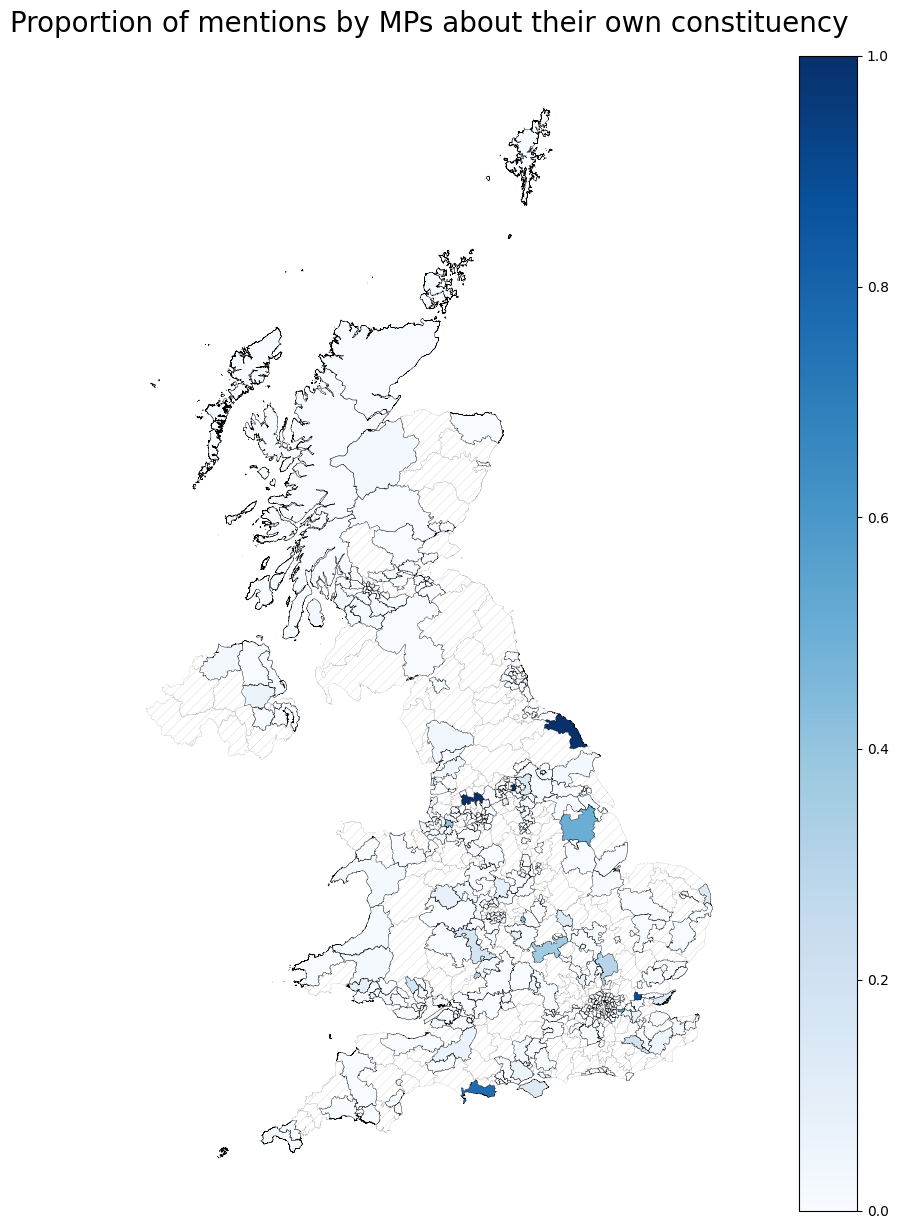

In [175]:
fig, ax = plt.subplots(figsize=(15, 15))
same_const.plot(ax=ax, column="proportion_same_const", legend=True, cmap="Blues", edgecolor="black", linewidth=0.3)
same_const[same_const["proportion_same_const"].isna()].plot(ax=ax, color="white", edgecolor="black", linewidth=0.1, hatch="///", alpha=0.5)
plt.rcParams['hatch.linewidth'] = 0.1
plt.title("Proportion of questions by MPs about their own constituency", fontsize=20)

ax.set_axis_off()